# WGAN-GP Training

## imports

In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt

from models.WGANGP import WGANGP
from utils.loaders import load_celeb

import pickle


In [2]:
# run params
SECTION = 'gan'
RUN_ID = '0003'
DATA_NAME = 'celeb'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

## data

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 64

In [4]:
x_train = load_celeb(DATA_NAME, IMAGE_SIZE, BATCH_SIZE)

Found 202599 images belonging to 1 classes.


In [5]:
x_train[0][0][0]

array([[[ 0.31764707,  0.33333334,  0.24705882],
        [ 0.24705882,  0.27058825,  0.12156863],
        [ 0.2627451 ,  0.29411766,  0.11372549],
        ...,
        [ 0.27058825,  0.3882353 ,  0.23921569],
        [ 0.3019608 ,  0.41960785,  0.27058825],
        [ 0.33333334,  0.39607844,  0.2784314 ]],

       [[ 0.31764707,  0.33333334,  0.24705882],
        [ 0.24705882,  0.27058825,  0.12156863],
        [ 0.2627451 ,  0.29411766,  0.11372549],
        ...,
        [ 0.27058825,  0.3882353 ,  0.23921569],
        [ 0.3019608 ,  0.41960785,  0.27058825],
        [ 0.33333334,  0.39607844,  0.2784314 ]],

       [[ 0.31764707,  0.33333334,  0.24705882],
        [ 0.25490198,  0.2784314 ,  0.12941177],
        [ 0.25490198,  0.28627452,  0.10588235],
        ...,
        [ 0.2784314 ,  0.39607844,  0.24705882],
        [ 0.29411766,  0.4117647 ,  0.2627451 ],
        [ 0.3254902 ,  0.3882353 ,  0.27058825]],

       ...,

       [[ 0.19215687,  0.23137255,  0.05882353],
        [ 0

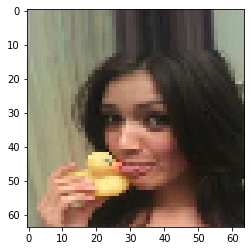

In [6]:
plt.imshow((x_train[0][0][0]+1)/2)

## architecture

In [7]:
gan = WGANGP(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , critic_conv_filters = [64,128,256,512]
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,2]
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.0002
        , generator_initial_dense_layer_size = (4, 4, 512)
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [256,128,64,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,2]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 100
        , batch_size = BATCH_SIZE
        )

if mode == 'build':
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
gan.critic.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 64, 64, 3)]       0         
_________________________________________________________________
critic_conv_0 (Conv2D)       multiple                  4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
critic_conv_1 (Conv2D)       multiple                  204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
critic_conv_2 (Conv2D)       multiple                  819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0     

In [9]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
generator_conv_0 (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024

## training

In [10]:
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5
BATCH_SIZE = 64

In [ ]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , using_generator = True
)

0 (5, 1) [D loss: (-2.8)(R -7.7, F 0.1, G 0.5)] [G loss: -5.2]


In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()
